# Boilerplate

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rpy2.robjects as rob
import seaborn as sns
from datetime import datetime
import os
import pickle
from scipy.special import logit
from tqdm import tqdm
import re
from itertools import islice
from collections import defaultdict
td = pd.datetools.timedelta
import networkx

INTRADE_PATH = '/home/jai/IntradeData/intrade/'

## GetData Functions

### Utility Functions

In [2]:
def hey(msg='hey'):
    def f(x):
        print msg
        return x
    return f

def mgroup(t):
    return t.groupby('market_id')

### Import CSVs

In [3]:
def read_trade_times(times):
    return [datetime.strptime(t, '%b/%d/%Y %H:%M:%S') for t in times]

def colname_fix(df):
    print 'Fixing column names...'
    columns = map(lambda x: re.sub(r'[\[\/\]]', '', x), df.columns)
    columns = map(lambda x: '_'.join(x.split(' ')), columns)
    df.rename(columns=dict(zip(df.columns, columns)), inplace=True)
    return df

def tradescsv_or_nothing(csv_path, intrade_path=INTRADE_PATH):
    try:
        df = pd.read_csv(csv_path, parse_dates=[5], date_parser=read_trade_times)
        category = csv_path.split(intrade_path)[1].split('/')[0]
        df['category'] = category
        return df
    except ValueError:
        return None
    
def get_trade_paths(intrade_path):
    trades=[]
    for dp, dn, fns in os.walk(intrade_path):
        sumfns = filter(lambda x: x.endswith('trades.csv'), fns)
        trades += map(lambda x: os.path.join(dp, x), sumfns)
    return trades

def read_trade_csvs(intrade_path):
    print 'Reading trade csvs...'
    readcsv = lambda csv_path: tradescsv_or_nothing(csv_path, intrade_path)
    return colname_fix(pd.concat(hey('Concatenating dfs...')(map(
                readcsv, 
                tqdm(get_trade_paths(intrade_path))
            ))))

def remove_weird_markets(trades):
    weird_mkts = \
        r'ELECTORALVOTES$|\-OPENING\.WEEKEND$|^LIV-EX100\.|^MEI.MOSES|^TOTAL.SEATS.|^ELEC.COL.VOTES'
    trades = trades[~trades.market_symbol.str.contains(weird_mkts)]
    trades = trades[~trades.market_id.isin((650479, 673548))]
    return trades.copy()

def get_trades(path=INTRADE_PATH, trades=None, tradesfname=None):
    if tradesfname is not None:
        print 'loading raw trading data from pickle...',
        trades = pload(tradesfname)
    else:
        trades = trades or read_trade_csvs(path)
    trades = trades[~trades.trade_price.isnull()].copy()
    trades = remove_weird_markets(trades)
    alls = (lambda t=None: slice(None))
    assignments = [
        (alls, 'market_symbol', lambda t: t.market_symbol.astype('category')),
        (alls, 'market_name', lambda t: t.market_name.astype('category')),
        (alls, 'p', lambda t: t.trade_price/100.),
        (alls, 'final_time', lambda t: mgroup(t).datetime_utc.transform('max')),
        (alls, 'final_p', lambda t: mgroup(t).p.transform('last')),
        (alls, 'countdown', lambda t: t.datetime_utc - t.final_time),
        (alls, 'hours', lambda t: (t.countdown.dt.total_seconds()/3600.).round(0)),
        (alls, 'days', lambda t: (t.countdown.dt.total_seconds()/86400.).round(0)),
        (alls, 'result', lambda t: np.full(t.shape[0], np.nan)),
        (lambda t: t.final_p>=0.95, 'result', lambda t: 1),
        (lambda t: t.final_p<=0.05, 'result', lambda t: 0),
        (alls, 'year', lambda t: t.datetime_utc.dt.year),
        (alls, 'final_year', lambda t: t.final_time.dt.year),
        (alls, 'start_time', lambda t: mgroup(t).datetime_utc.transform('min')),
        (alls, 'duration', lambda t: t.final_time - t.start_time),
        (alls, 'lodds', lambda t: np.log(t.p/(1.0 - t.p))),
    ]
    print ' * sorting by datetime * '
    trades.sort_values('datetime_utc', inplace=True)
    trades.set_index('datetime_utc', inplace=True, drop=False)
    print 'Adding columns...',
    for rowf, col, getvals in assignments:
        print col,
        trades.loc[rowf(trades), col] = getvals(trades.loc[rowf(trades), :])
    return trades.copy()

def get_market_info(trades):
    mt = mgroup(trades)
    market_info = mt.last()[[
        'market_symbol', 
        'market_name', 
        'category', 
        'final_time', 
        'start_time', 
        'final_p', 
        'duration',
        'final_year',
        'result'
    ]]
    market_info['total_volume'] = mt.trade_quantity.sum()
    market_info['num_trades'] = mt.market_id.count()
    return market_info

### Resampling

In [55]:
def floor_hour(times):
    """Given a time(delta), round down to hour (e.g. 11:34:15 becomes 11:00:00)"""
    c = times.dt.components
    tshift = c.minutes.apply(lambda x: td(minutes=x)) + c.seconds.apply(lambda x: td(seconds=x))
    return times - tshift

def align_first_countdown(trades):
    """Align first countdown to be an interger number of hours before 0"""
    starts = mgroup(trades).datetime_utc.transform('min')
    firsttrades = (trades.datetime_utc == starts)
    cds = trades.loc[firsttrades, 'countdown']
    trades.loc[firsttrades, 'countdown'] = floor_hour(cds)
    return trades

def mgroup_map(trades, f, col='p'):
    """Apply a function to all trade prices, by market. Useful for time resampling."""
    mg = mgroup(trades[['market_id', col]])
    return pd.concat(map(lambda x: f(mg.get_group(x)), mg.groups), axis=0)

def price_resampler_factory(period='H'):
    """Build price resampling function. Returned function works on single-market time-indexed df"""
    def resample_price(one_market_trades):
        return one_market_trades.resample(period).last().ffill()
    return resample_price

def volume_resampler_factory(period='H'):
    def resample_volume(one_market_trades):
        return one_market_trades.resample(period).sum().fillna(0)
    return resample_volume

def merge_market_info(p_df, market_df):
    return p_df.merge(market_df, left_on='market_id', right_index=True)

def loglossify(price_df):
    return np.log((price_df.p - (price_df.result==0)).abs())

def deluxifier(price_df, market_df):
    price_df = merge_market_info(price_df, market_df)
    price_df['logloss'] = loglossify(price_df)
    return price_df

def trades_to_price_by_date(trades, market_info=None):
    """Get prices by market/date"""
    dprices =  mgroup_map(trades, price_resampler_factory('D'))
    dvolume = mgroup_map(trades, volume_resampler_factory('D'), 'trade_quantity')
    dprices['volume'] = dvolume['trade_quantity']
    dprices['date']=dprices.index
    if market_info is not None:
        dprices = deluxifier(dprices, market_info)
    return dprices

def trades_to_price_by_countdown(trades, period='H', market_info=None):
    """Get prices by market/hours-until-closing"""
    cdtrades = align_first_countdown(trades.copy()).set_index('countdown')[['market_id', 'p']]
    cdprices = mgroup_map(cdtrades, price_resampler_factory(period))
    cdprices['countdown'] = cdprices.index
    if market_info is not None:
        cdprices = deluxifier(cdprices, market_info)
    return cdprices

## Get Data

In [9]:
trades = get_trades()
# trades = get_trades(tradesfname='raw_trades')

Reading trade csvs...


100%|██████████| 10821/10821 [00:52<00:00, 206.37it/s]


Concatenating dfs...
Fixing column names...
 * sorting by datetime * 
Adding columns... market_symbol market_name p final_time final_p countdown hours days result result result year final_year start_time duration lodds


In [10]:
market_info = get_market_info(trades)

In [27]:
daily_prices = trades_to_price_by_date(trades, market_info)

In [326]:
countdown_prices = trades_to_price_by_countdown(trades, 'H', market_info)
final60 = countdown_prices[
    (countdown_prices.duration > td(days=60)) & 
    (countdown_prices.countdown > -td(days=60))]

## Pickle

In [5]:
def ppath(name, base=INTRADE_PATH):
    return os.path.join(base, name + '.pickle')

def pdump(thing, name):
    with open(ppath(name), 'w+') as f:
        pickle.dump(thing, f, pickle.HIGHEST_PROTOCOL)

def pload(name):
    with open(ppath(name)) as f:
        x = pickle.load(f)
    return x

In [20]:
pdump(trades, 'trades')
pdump(market_info, 'market_info')
pdump(daily_prices, 'daily_prices')
pdump(countdown_prices, 'countdown_prices')

### Load Data From Pickles

In [7]:
trades = pload('trades')
market_info = pload('market_info')
daily_prices = pload('daily_prices')
countdown_prices = pload('countdown_prices')

## Colormaps

In [12]:
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    np.logspace
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap
cmap = sns.diverging_palette(h_neg=15, h_pos=255, s=99, l=35, sep=1, n=15, as_cmap=True)
scmap = shiftedColorMap(cmap, start=0.0, midpoint=0.33, stop=1.0)

# Analysis

## Example: GOP 2008 Nominee

<IPython.core.display.Javascript object>


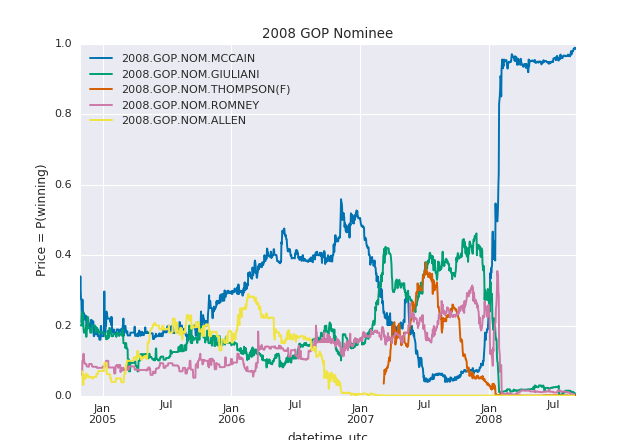

In [13]:
# select data
gop_nom = daily_prices[daily_prices.market_symbol.str.startswith('2008.GOP.NOM')]
peaks = gop_nom.groupby('market_symbol').p.max()
top_cands = peaks.sort_values(ascending=False).index[:5]

# plot
%matplotlib notebook

colors = sns.color_palette('colorblind', n_colors=5)
ax = plt.gca()
for cand in top_cands:
    vals = gop_nom[gop_nom.market_symbol==cand].p
    vals.plot(ax=ax, label=cand, color=colors.pop(0))
ax.set_title('2008 GOP Nominee')
ax.legend(loc='upper left');
ax.set_ylabel('Price = P(winning)');

## Categories

<IPython.core.display.Javascript object>


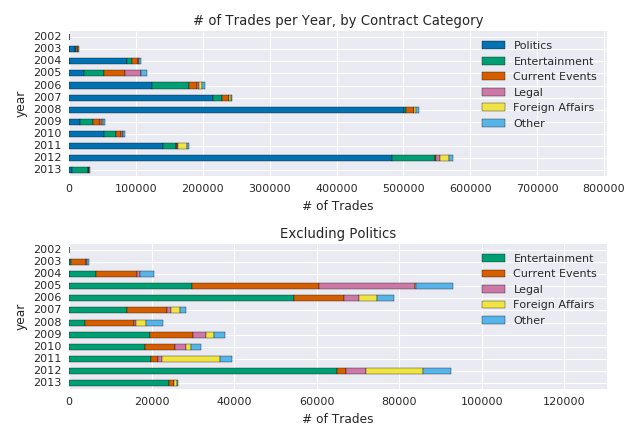

In [14]:
%matplotlib notebook

sns.set()

ncats = 5

color = sns.color_palette('colorblind', n_colors=(ncats+1))

f, (ax1, ax2) = plt.subplots(2,1, sharex=False, sharey=False)
catcounts = trades.groupby('category').market_id.count().sort_values(ascending=False)
bigcats = catcounts.index[:ncats]
smallcats = catcounts.index[ncats:]
catyears=trades.groupby(['year', 'category']).market_id.count().unstack('category')
smallcatcounts = catyears[smallcats].sum(axis=1)
catyears = catyears[bigcats]
catyears['Other'] = smallcatcounts
catyears.fillna(0, inplace=True)
catyears.sort_index(inplace=True, ascending=False)
ax1.grid(True)
catyears.plot.barh(stacked=True, color=color, ax=ax1)
ax1.legend(loc='upper right')
ax1.set_title('# of Trades per Year, by Contract Category')
ax1.set_xlim(0, max(catyears.sum(axis=1))*1.4)
ax1.set_xlabel('# of Trades')


othercats = filter(lambda cat: 'politics' not in cat.lower(), catyears.columns)
catyearsnp = catyears.loc[:, othercats]
catyearsnp.plot.barh(stacked=True, color=color[1:], ax=ax2)
ax2.legend(loc='upper right')
ax2.set_title('Excluding Politics');
ax2.set_xlim(0, max(catyearsnp.sum(axis=1))*1.4)
ax2.set_xlabel('# of Trades')
f.tight_layout()

## Active Markets Over Time

<IPython.core.display.Javascript object>


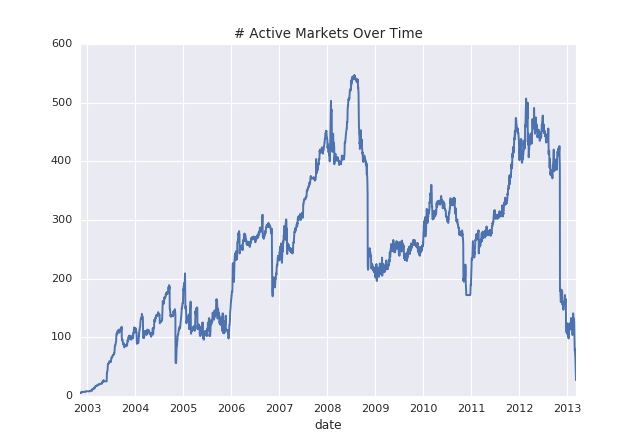

In [17]:
%matplotlib notebook
daily_prices.groupby('date').market_id.count().plot()
plt.title('# Active Markets Over Time');

## Performance

### Log Loss - Last 60 Days

<IPython.core.display.Javascript object>


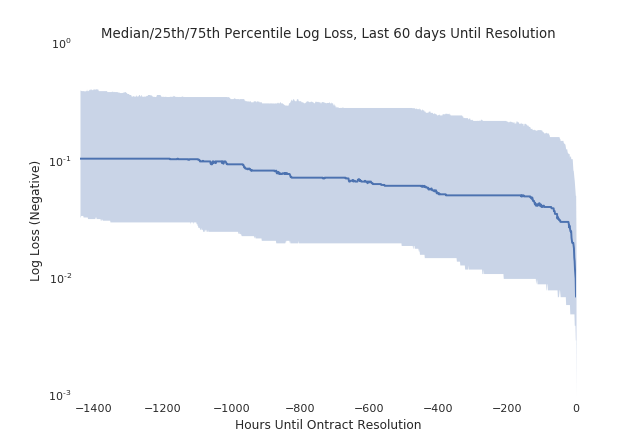

In [52]:
%matplotlib notebook
bycd = final60.groupby('countdown')
ll = bycd.logloss.median()
hours = ll.index.total_seconds()/3600
ll50 = -ll.values
ll25 = -bycd.logloss.quantile(0.25)
ll75 = -bycd.logloss.quantile(0.75)
plt.plot(hours, ll50)
plt.fill_between(hours, ll25, ll75, alpha=0.3, linewidth=0.0)
plt.yscale('log');
plt.xlim(hours.min(), hours.max())
plt.title('Median/25th/75th Percentile Log Loss, Last 60 days Until Resolution')
plt.xlabel('Hours Until Ontract Resolution')
plt.ylabel('Log Loss (Negative)');

#### By Year

In [53]:
yearlyll = {}
for y in xrange(2004, 2013):
    ll = dict()
    data = final60[final60.final_year==y]
    hb = data.groupby('countdown')
    ll['hours'] = hb.countdown.first()/3600000000000
    ll['05'] = -hb.logloss.quantile(0.05)
    ll['25'] = -hb.logloss.quantile(0.25)
    ll['50'] = -hb.logloss.median()
    ll['75'] = -hb.logloss.quantile(0.75)
    ll['95'] = -hb.logloss.quantile(0.95)
    yearlyll[y] = ll

<IPython.core.display.Javascript object>


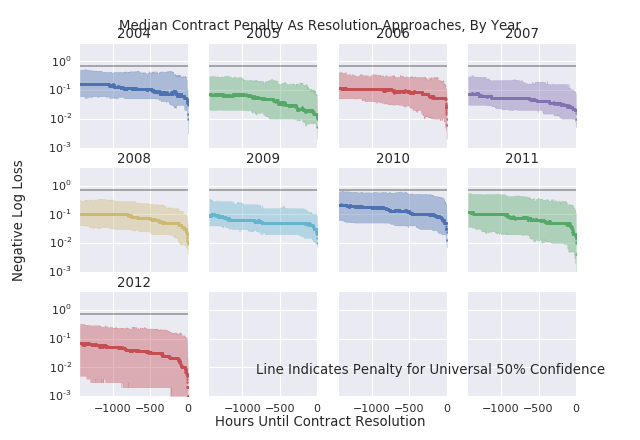

In [54]:
%matplotlib notebook
sns.set(rc={})

fig, axrows = plt.subplots(3, 4, sharex=True, sharey=True)
axes=[]
palette = sns.color_palette(n_colors=11)
for axrow in axrows:
    axes.extend(axrow)
for ax, y in zip(axes, yearlyll.iteritems()):
    color = palette.pop(0)
    year, ll = y
    sns.regplot(x=ll['hours'], y=ll['50'], fit_reg=False, ax=ax, label=year, marker='.', color=color)
    ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='coinflip baseline')
    ax.fill_between(ll['hours'], ll['25'], ll['75'], alpha=.4, color=color)
    ax.set_xlim(ll['hours'].min(), ll['hours'].max())
    ax.set_title(int(year))
    ax.locator_params(nbins=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
ax.set_yscale('log')
ax.set_ylim(0.001,4)
fig.text(0.5, 0.94, 'Median Contract Penalty As Resolution Approaches, By Year', ha='center', va='center')
fig.text(0.5, 0.04, 'Hours Until Contract Resolution', ha='center', va='center')
fig.text(0.03, 0.5, 'Negative Log Loss', ha='center', va='center', rotation='vertical')
fig.text(0.4, 0.15, 'Line Indicates Penalty for Universal 50% Confidence');

#### By Category

In [304]:
catll = {}
cats = ('Politics', 'Entertainment', 'Current Events', 'Legal', 'Foreign Affairs')
for c in cats:
    ll = dict()
    data = final60[final60.category==c]
    hb = data.groupby('countdown')
    ll['hours'] = hb.countdown.first()/3600000000000
    ll['05'] = -hb.logloss.quantile(0.05)
    ll['25'] = -hb.logloss.quantile(0.25)
    ll['50'] = -hb.logloss.median()
    ll['75'] = -hb.logloss.quantile(0.75)
    ll['95'] = -hb.logloss.quantile(0.95)
    catll[c] = ll

<IPython.core.display.Javascript object>


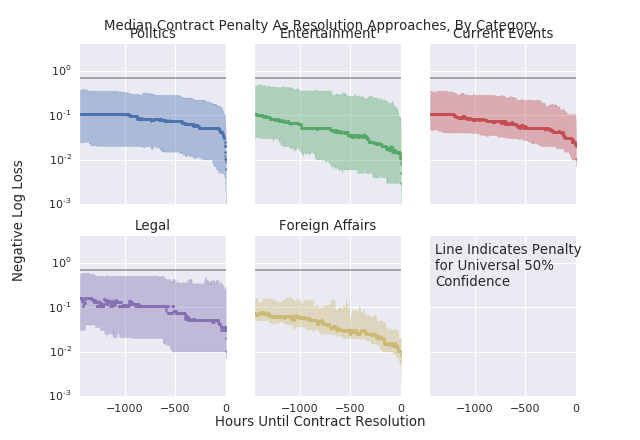

In [305]:
%matplotlib notebook
sns.set(rc={})

fig, axrows = plt.subplots(2, 3, sharex=True, sharey=True)
axes=[]
palette = sns.color_palette(n_colors=11)
for axrow in axrows:
    axes.extend(axrow)
for ax, cat in zip(axes, cats):
    color = palette.pop(0)
    ll = catll[cat]
    sns.regplot(x=ll['hours'], y=ll['50'], fit_reg=False, ax=ax, label=cat, marker='.', color=color)
    ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='coinflip baseline')
    ax.fill_between(ll['hours'], ll['25'], ll['75'], alpha=.4, color=color)
    ax.set_xlim(ll['hours'].min(), ll['hours'].max())
    ax.set_title(cat)
    ax.locator_params(nbins=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
ax.set_yscale('log')
ax.set_ylim(0.001,4)
fig.text(0.5, 0.94, 'Median Contract Penalty As Resolution Approaches, By Category', ha='center', va='center')
fig.text(0.5, 0.04, 'Hours Until Contract Resolution', ha='center', va='center')
fig.text(0.03, 0.5, 'Negative Log Loss', ha='center', va='center', rotation='vertical');
fig.text(0.68, 0.35, 'Line Indicates Penalty\nfor Universal 50% \nConfidence');

### Daily Log Loss (All time, All contracts)

In [29]:
daygrp = daily_prices.groupby('date')
volume = daygrp.volume.sum()
log_loss = -daygrp.logloss.median()
vlowlog_loss = -daygrp.logloss.quantile(0.05)
lowlog_loss = -daygrp.logloss.quantile(0.25)
highlog_loss = -daygrp.logloss.quantile(0.75)
vhighlog_loss = -daygrp.logloss.quantile(0.95)

<IPython.core.display.Javascript object>


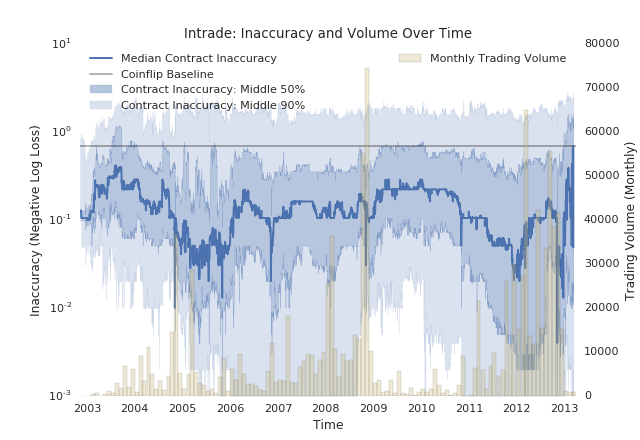

In [30]:
%matplotlib notebook
mvolume = volume.asfreq('M')
sns.set(rc={'figure.facecolor':'white', 'axes.facecolor':'white'})

colors = sns.color_palette()
colora = colors[0]
colorb = colors[4]

ax = plt.gca()
ax2 = ax.twinx()
ax.grid(False)
ax2.grid(False)
dates=log_loss.index
ax.set_yscale('log')

ax2.bar(mvolume.index, mvolume.values, color=colorb, width=30, alpha=0.3, label='Monthly Trading Volume')
ax.plot(log_loss.index, log_loss.values, '-', label='Median Contract Inaccuracy', color=colora)
ax.fill_between(dates, lowlog_loss, highlog_loss, alpha=.4, color=colora, label='Contract Inaccuracy: Middle 50%')
ax.fill_between(dates, vlowlog_loss, lowlog_loss, alpha=.2, color=colora, label='Contract Inaccuracy: Middle 90%')
ax.fill_between(dates, highlog_loss, vhighlog_loss, alpha=.2, color=colora)



ax.set_xlabel('Time')
ax.set_ylabel('Inaccuracy (Negative Log Loss)')
ax2.set_ylabel('Trading Volume (Monthly)')
ax.axhline(y=-np.log(0.5), color='black', alpha=0.3, label='Coinflip Baseline')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

ax.set_title("Intrade: Inaccuracy and Volume Over Time");

## Intrade <3 5

<IPython.core.display.Javascript object>


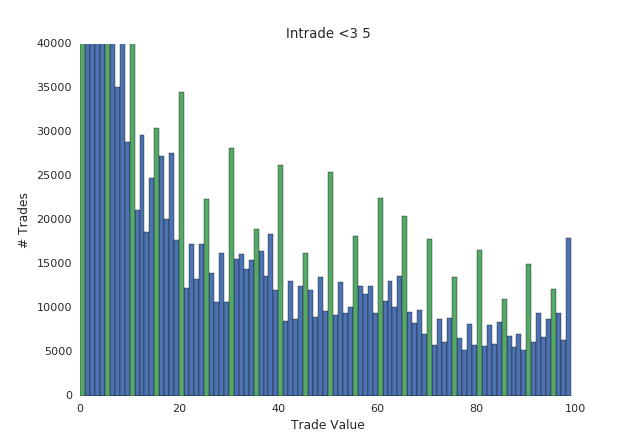

In [32]:
%matplotlib notebook
ax = plt.gca()
roundt = (100*trades.p).round(0)
roundt[roundt%5!=0].hist(bins=np.arange(100), ax=ax)
roundt[roundt%5==0].hist(bins=np.arange(100), ax=ax)
ax.set_ylim(0, 40000)
ax.set_title('Intrade <3 5')
ax.set_xlabel('Trade Value')
ax.set_ylabel('# Trades')

## Return on Investment

In [36]:
roidata = final60.loc[:, ['p', 'countdown', 'result', 'market_id']]
roidata['price'] = (roidata.p*10).round(0)*10
roidata['day'] = roidata.countdown.dt.days
roidata['roi'] = roidata.result / roidata.p

In [37]:
roidata = roidata.merge(market_info, left_on='market_id', right_index=True)

In [38]:
pdump(roidata, 'roidata')

In [82]:
def roiheatmap(roidata, ax=None, cbar=True, cbar_ax=None):
    ax = ax or plt.gca()
    binned = roidata.groupby(['price', 'day']).roi.mean().reset_index()
    pivoted = binned.pivot(index='price', columns='day', values='roi')
    ax.set_title('Expected ROI on Intrade Contracts')
    ax.set_xlabel('Days Until Contract Resolution')
    return sns.heatmap(pivoted, 
                       cmap=cmap, 
                       center=1.0, 
                       xticklabels=5, 
                       ax=ax, 
                       cbar=cbar, 
                       cbar_ax=cbar_ax);

### ROI vs (price, time until resolution)

<IPython.core.display.Javascript object>


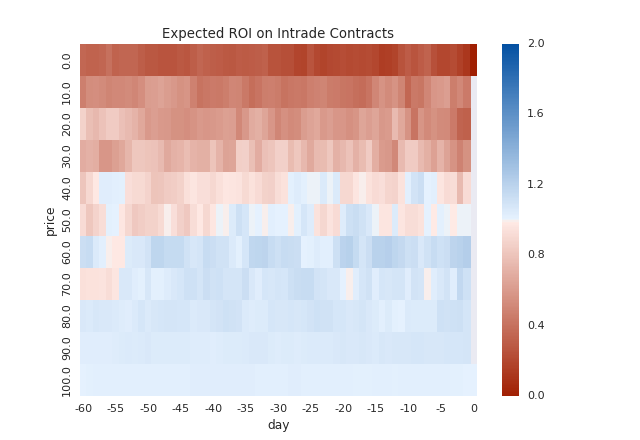

In [84]:
%matplotlib notebook
roiheatmap(roidata);

### ROI: Politics, Everything Else

<IPython.core.display.Javascript object>


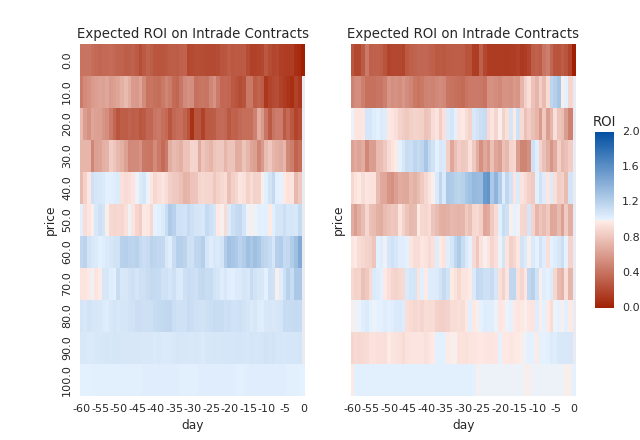

In [88]:
%matplotlib notebook
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.93, .3, .03, .4])
cbar_ax.set_title('ROI')
roiheatmap(roidata[roidata.category=='Politics'], ax1, cbar=False)
roiheatmap(roidata[roidata.category!='Politics'], ax2, cbar_ax=cbar_ax)

In [89]:
market_info[(market_info.category=='Politics') & (market_info.total_volume<100)].shape

(1379, 11)

<IPython.core.display.Javascript object>


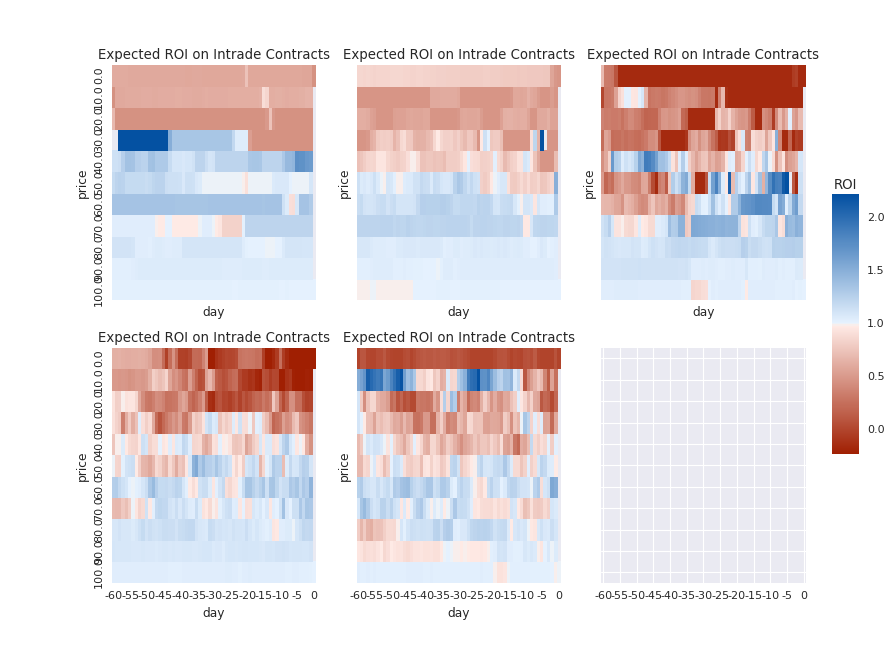

In [92]:
%matplotlib notebook
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharex=True, sharey=True)
cbar_ax = fig.add_axes([.93, .3, .03, .4])
cbar_ax.set_title('ROI')
roiheatmap(roidata[(roidata.category=='Politics') & (roidata.total_volume<100)], ax1, cbar=False)
roiheatmap(roidata[(roidata.category=='Politics') & (roidata.total_volume.between(100, 500))], ax2, cbar=False)
roiheatmap(roidata[(roidata.category=='Politics') & (roidata.total_volume.between(500, 1000))], ax3, cbar=False)
roiheatmap(roidata[(roidata.category=='Politics') & (roidata.total_volume.between(1000, 10000))], ax4, cbar=False)
roiheatmap(roidata[(roidata.category=='Politics') & (roidata.total_volume>10000)], ax5, cbar_ax=cbar_ax);

## Market Correlation

In [45]:
daily_prices['lodds'] = np.log(daily_prices.p/(1.0-daily_prices.p))
yesterlodds = daily_prices.lodds.shift(1)
daily_prices['loddsdiff'] = daily_prices.lodds - yesterlodds
start_days = (daily_prices.start_time.dt.date == daily_prices.date.dt.date).values
daily_prices.loc[start_days, 'loddsdiff'] = 0

In [46]:
interesting_tradedays = daily_prices[daily_prices.total_volume>100]
all_lods=interesting_tradedays.pivot(index='date', columns='market_id', values='loddsdiff')
all_lods[all_lods==0.0] = np.nan

In [47]:
corrs=all_lods.corr(min_periods=30)

In [48]:
uc=pd.DataFrame(corrs.unstack())
uc=uc.reset_index(0).rename(columns={'market_id': 'm1'}).reset_index().rename(columns={'market_id': 'm2'})
uc.rename(columns={0:'correlation'}, inplace=True)
uc.loc[uc.m1==uc.m2, 'correlation'] = np.nan
uc = uc[~uc.correlation.isnull()].copy()
uc['abscorrelation'] = uc.correlation.abs()
uc = uc.sort_values('abscorrelation', ascending=False)
mid_name = pd.DataFrame(market_info.market_symbol)
mid_cat = pd.DataFrame(market_info.category)
uc = uc.merge(mid_name, left_on='m1', right_index=True).rename(columns={'market_symbol': 'm1_name'})
uc = uc.merge(mid_name, left_on='m2', right_index=True).rename(columns={'market_symbol': 'm2_name'})
uc = uc.merge(mid_cat, left_on='m1', right_index=True).rename(columns={'category': 'm1_category'})
uc = uc.merge(mid_cat, left_on='m2', right_index=True).rename(columns={'category': 'm2_category'})

In [49]:
pdump(uc, 'market_correlation')

In [51]:
uc[(uc.m1_category!='Politics') & (uc.m2_category!='Politics')].sort_values('abscorrelation', ascending=False).iloc[:100,:]

,m2,m1,correlation,abscorrelation,m1_name,m2_name,m1_category,m2_category
5981651,315507.0,315541.0,0.970307,0.970307,ACTRESS.WITHERSPOON,ACTOR.HOFFMAN,Entertainment,Entertainment
5954981,315541.0,315507.0,0.970307,0.970307,ACTOR.HOFFMAN,ACTRESS.WITHERSPOON,Entertainment,Entertainment
6974181,337952.0,335411.0,-0.969657,0.969657,IDOL5.KATHARINE,IDOL5.MALE,Entertainment,Entertainment
7128867,335411.0,337952.0,-0.969657,0.969657,IDOL5.MALE,IDOL5.KATHARINE,Entertainment,Entertainment
6040341,315541.0,315558.0,-0.968593,0.968593,PICTURE.BROKEBACK,ACTRESS.WITHERSPOON,Entertainment,Entertainment
5981667,315558.0,315541.0,-0.968593,0.968593,ACTRESS.WITHERSPOON,PICTURE.BROKEBACK,Entertainment,Entertainment
5981661,315548.0,315541.0,-0.967126,0.967126,ACTRESS.WITHERSPOON,ACTRESS.HUFFMAN,Entertainment,Entertainment
6008331,315541.0,315548.0,-0.967126,0.967126,ACTRESS.HUFFMAN,ACTRESS.WITHERSPOON,Entertainment,Entertainment
5981676,315567.0,315541.0,0.960640,0.960640,ACTRESS.WITHERSPOON,PICTURE.CRASH,Entertainment,Entertainment
6088356,315541.0,315567.0,0.960640,0.960640,PICTURE.CRASH,ACTRESS.WITHERSPOON,Entertainment,Entertainment
